In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]

import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

#random.seed(1024)
%matplotlib inline

pd.options.display.max_rows=1000


In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch_MultiHead(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [4]:
def pad_to_batch_MultiHead(batch):
    x_text, x_ref, y, x_text_actual = zip(*batch)
    max_x_text = max([s.size(1) for s in x_text])
    x_p_text = []
    x_p_text_actual = []
    for i in range(len(batch)):
        if x_text[i].size(1) < max_x_text:
            x_p_text.append(torch.cat([x_text[i], Variable(LongTensor([inspire_data_stoi['_pad_']] * (max_x_text - x_text[i].size(1)))).view(1, -1)], 1))
        else:
            x_p_text.append(x_text[i])
        x_p_text_actual.append(x_text_actual)
    return torch.cat(x_p_text), torch.cat(x_ref), torch.cat(y).view(-1), x_p_text_actual

In [5]:
from fastai.text import (
    num_cpus,
    Tokenizer,
    partition_by_cores
)
from concurrent.futures import ProcessPoolExecutor
import re
from spacy.lang.en import English
from spacy.symbols import ORTH
import html
import collections

class FastLoadTokenizer(Tokenizer):
    """
    Tokenizer which avoids redundant loading of spacy language model

    The FastAI Tokenizer class loads all the pipeline components of the spacy model which significantly increases
    loading time, especially when doing inference on CPU. This class inherits from the FastAI Tokenizer and is
    refactored to avoid redundant loading of the classifier.
    """
    def __init__(self):
        self.re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
        self.tok = English()
        for w in ('<eos>', '<bos>', '<unk>'):
            self.tok.tokenizer.add_special_case(w, [{ORTH: w}])

    def proc_all(self, ss):
        return [self.proc_text(s) for s in ss]

    def proc_all_mp(self, ss, ncpus=None):
        ncpus = ncpus or num_cpus() // 2
        with ProcessPoolExecutor(ncpus) as executor:
            return sum(executor.map(self.proc_all, ss), [])

/root/py36venv/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
re1 = re.compile(r'  +')
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag


def get_texts(df):
    labels = df['labels'].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = list(texts.apply(fixup).values)

    tokens = FastLoadTokenizer().proc_all_mp(partition_by_cores(texts))
    return tokens, list(labels)


def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

## Data Loading and Pre-processing

In [7]:
training_dataframe = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_augmented_train_corrected.df')
validation_dataframe = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_augmented_test_corrected.df')

In [8]:
means = training_dataframe.iloc[:,:-2].mean().values
stds = validation_dataframe.iloc[:,:-2].std().values

training_dataframe.iloc[:,:-2] = (training_dataframe.iloc[:,:-2] - means) / stds
validation_dataframe.iloc[:,:-2] = (validation_dataframe.iloc[:,:-2] - means) / stds

In [9]:
training_tokens, training_labels = get_texts(training_dataframe)
validation_tokens, validation_labels = get_texts(validation_dataframe)

In [10]:
MAX_VOCAB_SIZE = 80000
MINIMUM_FREQUENCY = 2

word_frequency = collections.Counter(p for o in training_tokens for p in o)
inspire_data_itos = [o for o, c in word_frequency.most_common(MAX_VOCAB_SIZE) if c > MINIMUM_FREQUENCY]
inspire_data_itos.insert(0, '_pad_')
inspire_data_itos.insert(0, '_unk_')
inspire_data_stoi = collections.defaultdict(lambda: 0, {v: k for k, v in enumerate(inspire_data_itos)})

training_token_ids = np.array([[inspire_data_stoi[o] for o in p] for p in training_tokens])
validation_token_ids = np.array([[inspire_data_stoi[o] for o in p] for p in validation_tokens])

In [11]:
X_train = training_token_ids
X_train_core1 = list(training_dataframe['core_references_fraction_first_order'])
X_train_core2 = list(training_dataframe['core_references_fraction_second_order'])
X_train_noncore1 = list(training_dataframe['noncore_references_fraction_first_order'])
X_train_noncore2 = list(training_dataframe['noncore_references_fraction_second_order'])
X_train_num_refs1 = list(training_dataframe['total_first_order_references'])
X_train_num_refs2 = list(training_dataframe['total_second_order_references'])
y_train = training_labels

In [12]:
# Get the class weights
rejected_count = y_train.count(0)
noncore_count = y_train.count(1)
core_count = y_train.count(2)

total_count = len(y_train)

inverse_rejected_fraction = total_count / rejected_count
inverse_noncore_fraction = total_count / noncore_count
inverse_core_fraction = total_count / core_count 

sum_fractions = inverse_rejected_fraction + inverse_noncore_fraction + inverse_core_fraction

# Specify the class weights (for the loss function specified later)
class_weights = torch.cuda.FloatTensor((inverse_rejected_fraction/sum_fractions,
                                        inverse_noncore_fraction/sum_fractions,
                                        inverse_core_fraction/sum_fractions))

In [13]:
class_weights = class_weights / class_weights[1]
print(class_weights)

tensor([1.8749, 1.0000, 1.1123], device='cuda:0')


In [14]:
X_val = validation_token_ids
X_val_core1 = list(validation_dataframe['core_references_fraction_first_order'])
X_val_core2 = list(validation_dataframe['core_references_fraction_second_order'])
X_val_noncore1 = list(validation_dataframe['noncore_references_fraction_first_order'])
X_val_noncore2 = list(validation_dataframe['noncore_references_fraction_second_order'])
X_val_num_refs1 = list(validation_dataframe['total_first_order_references'])
X_val_num_refs2 = list(validation_dataframe['total_second_order_references'])
y_val = validation_labels

In [15]:
def zip_data(text, core1, core2, noncore1, noncore2, num_refs1, num_refs2, y, actual_text):
    X_p_text, X_p_ref, y_p, X_text_actual = [], [], [], []
    for pair in zip(text, core1, core2, noncore1, noncore2, num_refs1, num_refs2, y, actual_text):
        X_p_text.append(Variable(LongTensor(pair[0])).view(1, -1))
        X_p_ref.append(Variable(FloatTensor([pair[1], pair[2], pair[3], pair[4], pair[5], pair[6]])).view(1, -1))
        y_p.append(Variable(LongTensor([pair[7]])).view(1, -1))
        X_text_actual.append(pair[8])
        
    return list(zip(X_p_text, X_p_ref, y_p, X_text_actual))

In [16]:
training_data = zip_data(X_train, X_train_core1, X_train_core2, X_train_noncore1, 
                         X_train_noncore2, X_train_num_refs1, X_train_num_refs2, 
                         y_train, training_dataframe.text)
validation_data = zip_data(X_val, X_val_core1, X_val_core2, X_val_noncore1, 
                         X_val_noncore2, X_val_num_refs1, X_val_num_refs2, 
                         y_val, validation_dataframe.text)

stoi = [k for k in inspire_data_stoi.keys()]

pickle.dump(stoi, open('inspire_data_with_reference_fractions_and_num_references/temp_stoi.pkl', 'wb'))

pickle.dump(training_data, open('inspire_data_with_reference_fractions_and_num_references/processed_data_augmented_train_corrected.pkl', 'wb'))
pickle.dump(validation_data, open('inspire_data_with_reference_fractions_and_num_references/processed_data_augmented_val_corrected.pkl', 'wb'))

##### Load pre-trained Word Vectors

import gensim

# text_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
text_model = gensim.models.FastText.load_fasttext_format('data/cc.en.300.bin', full_model=False)

len(text_model.index2word)

y_list, n_list = [], []
for key in inspire_data_stoi.keys():
    try:
        text_model.wv.get_vector(key)
        y_list.append(key)
    except:
        n_list.append(key)
(len(y_list), len(n_list))

pretrained = []

for key in inspire_data_stoi.keys():
    try:
        pretrained.append(text_model.wv.get_vector(key))
    except:
        pretrained.append(np.random.randn(300))

pretrained_vectors = np.vstack(pretrained)

In [17]:
pretrained_vectors = np.load('inspire_data_with_reference_fractions_and_num_references/pretrained_fasttext.npy')

## Train

In [97]:
EPOCH = 1
BATCH_SIZE = 64
KERNEL_SIZES = [3,4,5,6]
KERNEL_DIM = 200
DROPOUT = 0.2
LR = 0.001
REF_FC_LAYER1_DIM = 200
REF_FC_LAYER2_DIM = 100

In [98]:
class  CNN_Classifier_MultiHead(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5,
                 ref_fc_layer1_dim=200, ref_fc_layer2_dim=100):
        super(CNN_Classifier_MultiHead,self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])
        self.bn_conv = nn.BatchNorm2d(200)

        # FC Layer for the reference fractions
        self.fc_reference_fraction1 = nn.Linear(6, ref_fc_layer1_dim)
        self.bn_fcr1 = nn.BatchNorm1d(ref_fc_layer1_dim)
        self.fc_reference_fraction2 = nn.Linear(ref_fc_layer1_dim, ref_fc_layer2_dim)
        self.bn_fcr2 = nn.BatchNorm1d(ref_fc_layer2_dim)
        
        # kernal_size = (K,D) 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim + ref_fc_layer2_dim, output_size)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, text_inputs, reference_fraction_inputs, is_training=False):
        text_inputs = self.embedding(text_inputs).unsqueeze(1) # (B,1,T,D)
        text_inputs = [F.relu(self.bn_conv(conv(text_inputs))).squeeze(3) for conv in self.convs] #[(N,Co,W), ...]*len(Ks)
        text_inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in text_inputs] #[(N,Co), ...]*len(Ks)

        concated = torch.cat(text_inputs, dim=1)
        
        reference_fraction_out = self.bn_fcr1(self.fc_reference_fraction1(reference_fraction_inputs))
        reference_fraction_out2 = self.bn_fcr2(self.fc_reference_fraction2(reference_fraction_out))
        super_concatenated = torch.cat((concated, reference_fraction_out2), dim=1)

        if is_training:
            super_concatenated = self.dropout(super_concatenated) # (N,len(Ks)*Co)
        out = self.fc(super_concatenated)
        return F.log_softmax(out,1)

In [99]:
model = CNN_Classifier_MultiHead(len(inspire_data_itos), 300, len(set(y_train)), KERNEL_DIM, KERNEL_SIZES, dropout=DROPOUT,
                                ref_fc_layer1_dim=REF_FC_LAYER1_DIM, ref_fc_layer2_dim=REF_FC_LAYER2_DIM)
model.init_weights(pretrained_vectors, is_static=False) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam([
    {'params': model.embedding.parameters(), 'lr': 0.0001},
    {'params': model.convs.parameters()},
    {'params': model.dropout.parameters()}, 
    {'params': model.fc.parameters()},
    {'params': model.bn_conv.parameters()},
    {'params': model.bn_fcr1.parameters()},
    {'params': model.bn_fcr2.parameters()},
    {'params': model.fc_reference_fraction1.parameters()},
    {'params': model.fc_reference_fraction2.parameters()}
], lr=LR)
# optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [100]:
print(model)

CNN_Classifier_MultiHead(
  (embedding): Embedding(80002, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (bn_conv): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_reference_fraction1): Linear(in_features=6, out_features=200, bias=True)
  (bn_fcr1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_reference_fraction2): Linear(in_features=200, out_features=100, bias=True)
  (bn_fcr2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=900, out_features=3, bias=True)
)


In [101]:
def train_model(train_data, model, loss_function, epoch):
    '''
    Trains the model for one epoch
    '''
    
    model.train()
    avg_loss = []
    avg_train_acc = []
    
    for i, batch in enumerate(getBatch_MultiHead(BATCH_SIZE, train_data)):
        text_inputs, reference_fraction_inputs, targets, _ = pad_to_batch_MultiHead(batch)
        
        model.zero_grad()
        preds = model(text_inputs, reference_fraction_inputs, True)
        
        loss = loss_function(preds, targets)
        loss.backward()
        
        optimizer.step()
        
        train_acc = (sum(preds.max(1)[1] == targets).item() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('TRAIN [Epoch : {}/{}][Batch: {}] Batch Train Loss: {}, Batch Train Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.item(),
                                                                                                train_acc))
    
        avg_loss.append(loss.item())
        avg_train_acc.append(train_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_train_acc = np.mean(avg_train_acc)

    return avg_loss, avg_train_acc

def validate(val_data, model, loss_function, epoch):
    
    model.eval()
    avg_loss = []
    avg_test_acc = []
    
    for i, batch in enumerate(getBatch_MultiHead(BATCH_SIZE, val_data)):
        text_inputs, reference_fraction_inputs, targets, _ = pad_to_batch_MultiHead(batch)
        
        preds = model(text_inputs, reference_fraction_inputs, False)
        
        loss = loss_function(preds, targets)
        
        test_acc = (sum(preds.max(1)[1] == targets).item() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('VAL [Epoch : {}/{}][Batch: {}] Batch Test Loss: {}, Batch Test Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.item(),
                                                                                                test_acc))
    
        avg_loss.append(loss.item())
        avg_test_acc.append(test_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_test_acc = np.mean(avg_test_acc)

    return avg_loss, avg_test_acc

In [168]:
# train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(EPOCH):
    
    scheduler.step()
    
    print('<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>')
    epoch_train_loss, epoch_train_acc = train_model(training_data, model, loss_function, epoch)
    print('[TRAIN] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_train_loss, epoch_train_acc))
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    
    print('<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>')
    epoch_val_loss, epoch_val_acc = validate(validation_data, model, loss_function, epoch)
    print('[VAL] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_val_loss, epoch_val_acc))    
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 0/1][Batch: 0] Batch Train Loss: 0.0781983882188797, Batch Train Accuracy: 95.3125
TRAIN [Epoch : 0/1][Batch: 100] Batch Train Loss: 0.032114800065755844, Batch Train Accuracy: 100.0
TRAIN [Epoch : 0/1][Batch: 200] Batch Train Loss: 0.09298940747976303, Batch Train Accuracy: 93.75
TRAIN [Epoch : 0/1][Batch: 300] Batch Train Loss: 0.055411502718925476, Batch Train Accuracy: 96.875
TRAIN [Epoch : 0/1][Batch: 400] Batch Train Loss: 0.12329299747943878, Batch Train Accuracy: 96.875
TRAIN [Epoch : 0/1][Batch: 500] Batch Train Loss: 0.031203288584947586, Batch Train Accuracy: 96.875
TRAIN [Epoch : 0/1][Batch: 600] Batch Train Loss: 0.04309370368719101, Batch Train Accuracy: 95.3125
TRAIN [Epoch : 0/1][Batch: 700] Batch Train Loss: 0.07187002897262573, Batch Train Accuracy: 98.4375
TRAIN [Epoch : 0/1][Batch: 800] Batch Train Loss: 0.07793021202087402, Batch Train Accuracy: 96.875
TRAIN [Epoch : 0/1][Batch: 900] Batch Train Loss: 0.0680641457438

#### Make loss and accuracy plots

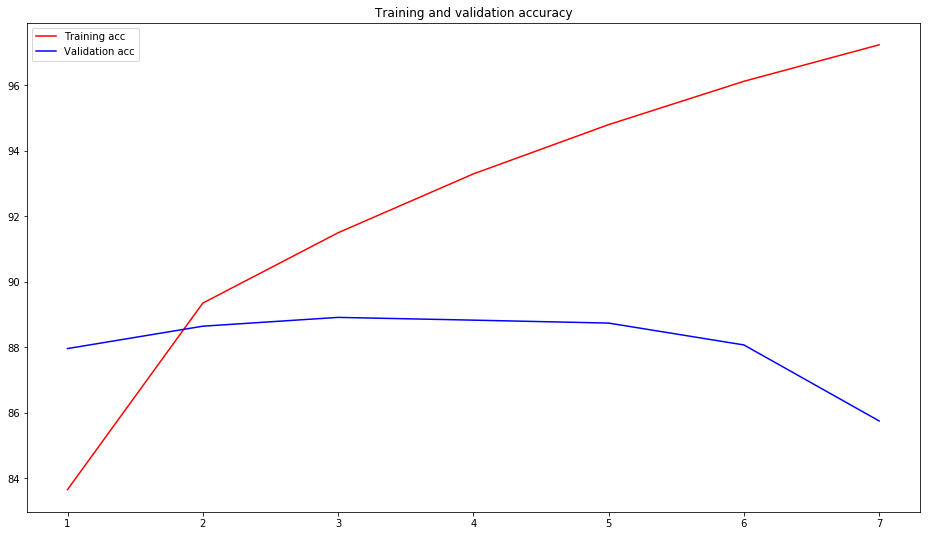

In [169]:
# Accuracy
epochs = range(1, 7*EPOCH + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

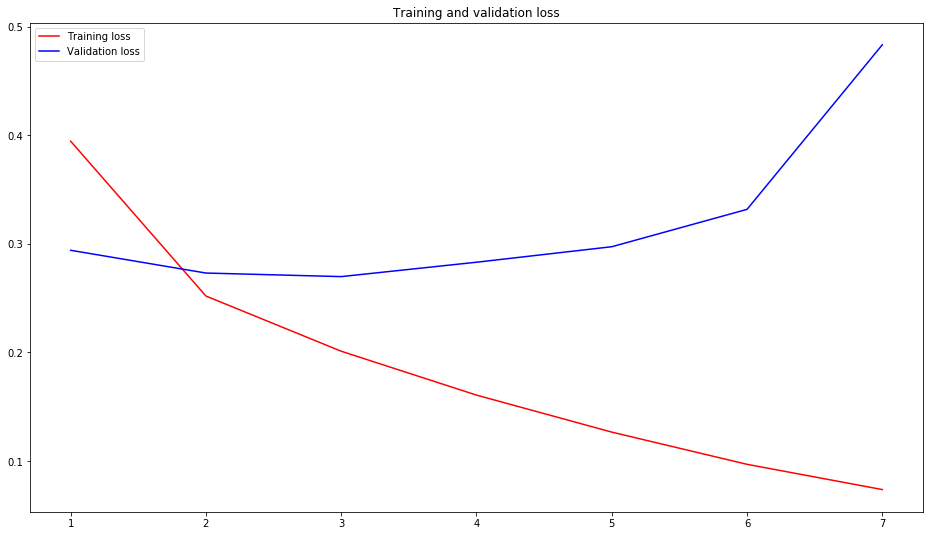

In [170]:
# Loss

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate on validation set

accuracy = 0

for test in val_data:
    pred = model(test[0], test[1], False).max(1)[1]
    pred = pred.data.tolist()[0]
    target = test[1].data.tolist()[0][0]
    if pred == target:
        accuracy += 1

print(accuracy/len(val_data) * 100)

In [171]:
if 'Y_VAL' in locals():
    del Y_VAL, Y_VAL_PREDS

actual_text = []
encoded_text = []
ref_fracs = []
labels = []
predicted = []

for data in getBatch_MultiHead(50, validation_data):
    text_inputs, ref_inputs, targets, text_actual = pad_to_batch_MultiHead(data)

    y_val_pred = model(text_inputs, ref_inputs, False)
    preds = y_val_pred.max(1)[1]
    
    if 'Y_VAL' in locals():
        Y_VAL = torch.cat((Y_VAL, targets), 0)
        Y_VAL_PREDS = torch.cat((Y_VAL_PREDS, preds), 0)
    else:
        Y_VAL = targets
        Y_VAL_PREDS = preds
        
    encoded_text.append(text_inputs)
    actual_text.append(text_actual)
    ref_fracs.append(ref_inputs)
    labels.append(targets)
    predicted.append(preds)

In [172]:
enc_text = [text.cpu().numpy() for text_list in encoded_text for text in text_list]
raw_text = [text for text_list in actual_text for text in text_list[0]]
ref_fractions = [tuple(ref_f.cpu().numpy()) for sublist in ref_fracs for ref_f in sublist]
pd_labels = [l.item() for sublist in labels for l in sublist]
pd_predicted = [p.item() for sublist in predicted for p in sublist]

In [173]:
from sklearn.metrics import confusion_matrix

In [174]:
conf_mat = confusion_matrix(pd_labels, pd_predicted, labels = [0, 1, 2])

In [175]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.76495 0.22095 0.0141 ]
 [0.01481 0.90373 0.08146]
 [0.00272 0.13723 0.86005]]


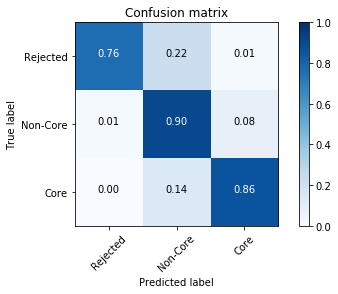

In [176]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

Confusion matrix, without normalization
[[ 9223  2664   170]
 [  343 20924  1886]
 [   56  2826 17711]]


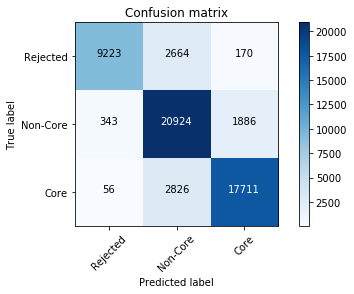

In [177]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=False)
plt.show()

### Look at the mismatches

In [53]:
predictions = pd.DataFrame(data={'text': raw_text, 'encoded_text': enc_text, 'ref_fractions': ref_fractions, 'label': pd_labels, 'pred': pd_predicted})

In [105]:
predictions.to_pickle('inspire_data_with_reference_fractions_and_num_references/predictions_ulmfit_preprocessing.pkl')

In [62]:
predictions.head()

,text,encoded_text,ref_fractions,label,pred
0,Transverse Field Perturbation For PIP-II SRF C...,"[21, 26, 27, 20, 441, 50, 891, 12, 10, 8277, 6...","(-1.645081e-05, -0.61458623, -0.10288895, -0.8...",2,1
1,A framework of Rogers–Ramanujan identities and...,"[21, 26, 27, 20, 9, 281, 3, 16516, 140, 10982,...","(-0.6785068, 0.27651313, -0.62129873, -0.29390...",1,1
2,Robust quantum coherence above the Fermi sea <...,"[21, 26, 27, 20, 1268, 72, 2258, 519, 2, 676, ...","(-0.7825089, -0.84908605, -0.7329562, -0.86312...",0,0
3,FIFRELIN – TRIPOLI-4® coupling for Monte Carlo...,"[21, 26, 27, 20, 10, 46957, 140, 10, 21698, 84...","(-0.7825089, -0.8274399, 1.1047399, 1.133549, ...",1,1
4,"Demonstrating High-precision, Multiband Transi...","[21, 26, 27, 20, 3594, 55, 6, 552, 5, 8043, 58...","(-0.7825089, -0.84908605, -0.7329562, -0.86312...",0,0


In [73]:
pred_rejected_but_core = predictions[(predictions.label == 2) &  (predictions.pred == 0)]

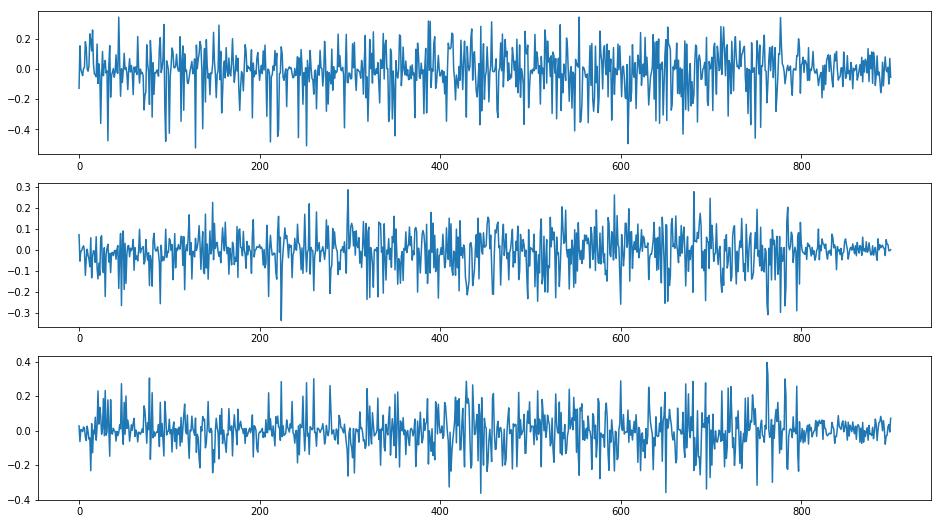

In [178]:
plt.figure(figsize=(16, 9))
plt.subplot(311)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,0])
plt.subplot(312)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,1])
plt.subplot(313)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,2])

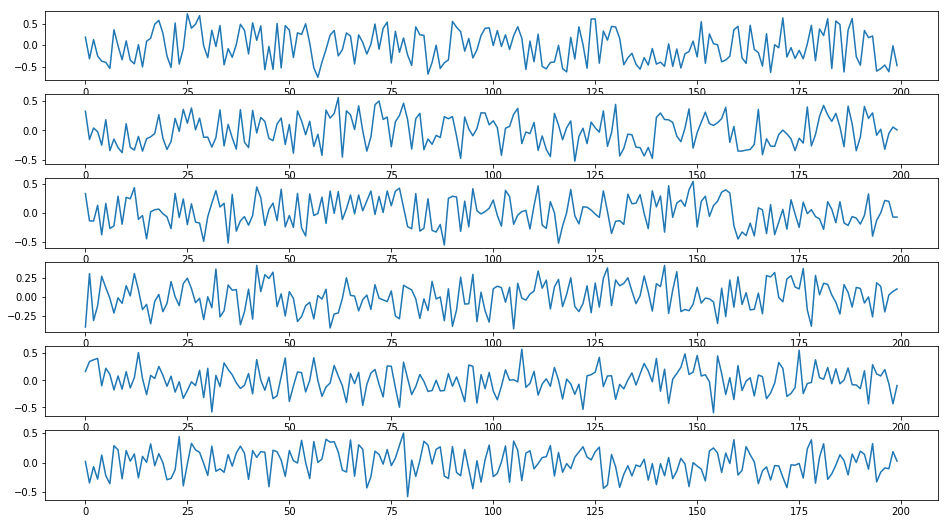

In [156]:
plt.figure(figsize=(16, 9))
plt.subplot(611)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,0])
plt.subplot(612)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,1])
plt.subplot(613)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,2])
plt.subplot(614)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,3])
plt.subplot(615)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,4])
plt.subplot(616)
plt.plot(model.fc_reference_fraction1.weight.cpu().detach().numpy()[:,5])

In [180]:
model

CNN_Classifier_MultiHead(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (bn_conv): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_reference_fraction1): Linear(in_features=6, out_features=200, bias=True)
  (bn_fcr1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_reference_fraction2): Linear(in_features=200, out_features=100, bias=True)
  (bn_fcr2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=900, out_features=3, bias=True)
)

In [181]:
(
    (model.fc.weight.cpu().detach().numpy().T[:,0].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,0].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,0].mean()
    ),
    (model.fc.weight.cpu().detach().numpy().T[:,1].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,1].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,1].mean()
    ),
    (model.fc.weight.cpu().detach().numpy().T[:,2].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,2].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,2].mean()
    )
)

((-0.004086509, -0.0032845945, -0.010501824),
 (0.0001526185, -0.0003817659, 0.0044276956),
 (0.00088355056, 3.0283667e-05, 0.0077096857))

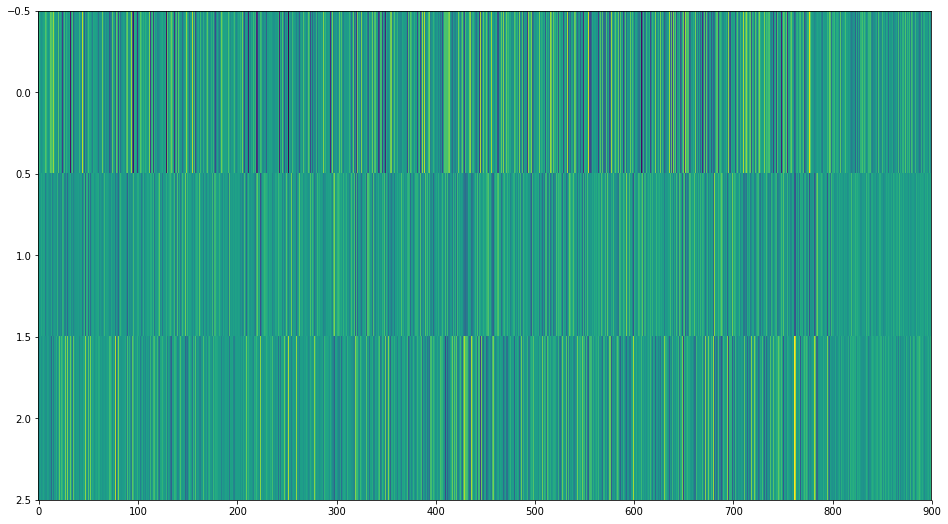

In [157]:
plt.figure(figsize=(16, 9))
plt.imshow(model.fc.weight.cpu().detach().numpy(), aspect='auto')

CNN_Classifier_MultiHead(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (fc_reference_fraction): Linear(in_features=4, out_features=200, bias=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=1000, out_features=3, bias=True)
)